# import

In [1]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=True, na_dict=None,
             preproc_fn=None, max_n_cat=10, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is not None: 
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    if y_fld is not None: 
        res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    else:
        res = [pd.get_dummies(df, dummy_na=True), na_dict]
    if do_scale: res = res + [mapper]
    return res

In [3]:
import pdb
import gc

# read data

In [186]:
df_train = pd.read_csv('/media/zero/dropbox/Dropbox/Data science project/kaggle/home_credit_default_risk/data/application_train.csv')

In [187]:
df_train = df_train[:100000]

In [188]:
train_cats(df_train)
y_label = df_train['TARGET'].values

In [189]:
keep_ft = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_DOCUMENT_3',
         'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'TOTALAREA_MODE',
           'DEF_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE', 'HOUR_APPR_PROCESS_START', 
           'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
           'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
           'AMT_ANNUITY', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [190]:
df_train = df_train[keep_ft]
x_train,x_valid, y_train, y_valid = train_test_split(df_train, y_label, test_size=0.25, stratify = y_label)

In [191]:
train_proc, train_na, mapper = proc_df2(x_train)
valid_proc, valid_na, _ =  proc_df2(x_valid, na_dict = train_na, mapper= mapper)

In [192]:
valid_proc.drop(['AMT_ANNUITY_na'], axis=1, inplace=True)

In [193]:
del df_train, y_label, x_train, x_valid; gc.collect()

259

# data loader

In [194]:
class cstmz_dataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x.values.astype(np.float32), np.array(y, dtype=np.float32)

    def __len__(self): return len(self.y)
        
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

In [195]:
class cstmz_md(ModelData):    
    @classmethod
    def get_dataset(cls, path, x_tr, y_tr, x_val, y_val, bs = 16, shuffle = False, num_workers=4):
        trn_ds = cstmz_dataset(x_tr, y_tr)
        val_ds = cstmz_dataset(x_val, y_val)
        return cls.get_dl(path, trn_ds, val_ds, bs, shuffle)
    
    @classmethod
    def get_dl(cls, path, trn_ds, val_ds, bs = 16, shuffle = False, num_workers=4):
        trn_dl = DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=num_workers)
        val_dl = DataLoader(val_ds, bs, shuffle=shuffle, num_workers=num_workers)
        return cls(path, trn_dl, val_dl, None)

In [196]:
model_data = cstmz_md.get_dataset('', train_proc, y_train, valid_proc, y_valid, bs = 64)

# Architechture

In [273]:
class linear_block(nn.Module):
    def __init__(self, ip_sz, op_sz, drop):
        super().__init__()
        self.op_sz = op_sz
        self.ln = nn.Linear(ip_sz, op_sz)
        kaiming_normal(self.ln.weight.data)
        if drop is not None:
            self.bn = nn.BatchNorm1d(op_sz)
            self.drp = nn.Dropout(drop)
        
    def forward(self, x): return self.drp(self.bn(F.relu(self.ln(x)))) if self.op_sz != 1 else self.ln(x)

In [274]:
class ctmz_Model(nn.Module):
    def __init__(self, layers, drp_rt):  
        super().__init__()
        layers = [29] + layers + [1]    
        drp_rt = drp_rt + [None]
        self.lins = nn.ModuleList([linear_block(layers[i], layers[i+1], drp_rt[i]) for i in range(len(layers)-1)])
        
    def forward(self, x):
        for lyer in self.lins: x = lyer(x)
        return x.view(-1)

In [275]:
model = ctmz_Model(layers = [128, 64, 32], drp_rt = [0.15, 0.15, 0.25])

# leaner

In [276]:
def imbalance_loss(inp,targ): return F.binary_cross_entropy_with_logits(inp, targ, targ*0.6 + 0.2)

In [280]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = imbalance_loss

In [281]:
ff_learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

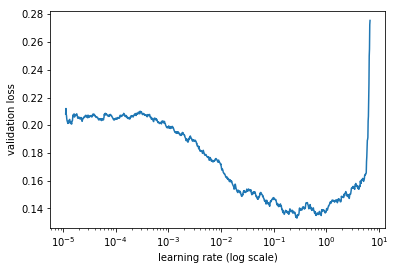

In [282]:
ff_learner.sched.plot()

# find learning rate and weight decay

In [266]:
wds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

In [267]:
trn_losses, lrs = [], []

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.144483   0.145605  


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.144482   0.145604  


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.144467   0.145601  


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.144351   0.145699  


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.14529    0.148399  


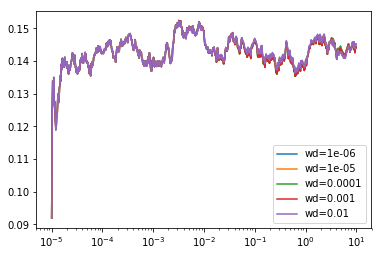

In [268]:
fig, ax = plt.subplots(1,1)
for wd in wds:
    ff_learner = Learner.from_model_data(model, model_data)
    ff_learner.crit = imbalance_loss
    ff_learner.lr_find(wds=wd)
    trn_losses.append(ff_learner.sched.losses)
    lrs.append(ff_learner.sched.lrs)    
    ax.plot(ff_learner.sched.lrs,
            ff_learner.sched.losses, 
            label= 'wd=' + str(wd))

ax.set_xscale('log')
ax.legend(loc='best')

In [202]:
ff_learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 1135/1172 [00:07<00:00, 155.89it/s, loss=0.25] 

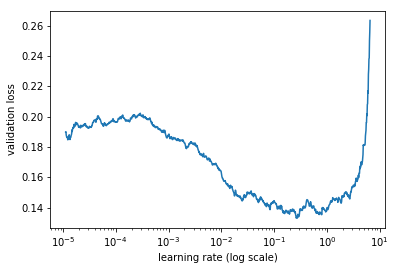

In [203]:
ff_learner.sched.plot()

# fit

## first fit

In [104]:
# we use learning rate that back 1 step that lowest learning rate
lrs = 1e-1

In [105]:
ff_learner.fit(lrs, n_cycle= 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.130847   0.134273  


[array([0.13427])]

## schotastic with restart

### cycle len = 1

In [163]:
ff_learner.fit(lrs, n_cycle= 3, cycle_len= 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.36565    0.350774  
    1      0.367257   0.351126                                 
    2      0.367218   0.353856                                 


[array([0.35386])]

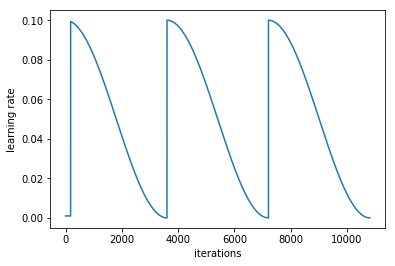

In [164]:
# cycle_len= 1 after one epoch, lets change learning rate
ff_learner.sched.plot_lr()

### cycle len = 3

cycle len need equal or less than n cycle

In [109]:
ff_learner.fit(lrs, n_cycle=3, cycle_len= 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.12492    0.127473  
    1      0.123753   0.126324                                
    2      0.122787   0.125327                                
    3      0.122734   0.126973                                
    4      0.123125   0.126228                                
    5      0.12278    0.125422                                
    6      0.123912   0.126611                                
    7      0.123113   0.126524                                
    8      0.123196   0.125324                                


[array([0.12532])]

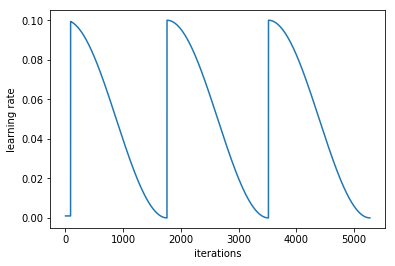

In [110]:
ff_learner.sched.plot_lr()

## cycle mult

In [170]:
lrs = 1e-1

In [171]:
ff_learner.fit(lrs, n_cycle= 2, cycle_len= 1, cycle_mult= 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.368264   0.350502  
    1      0.368358   0.35114                                  
    2      0.364278   0.350019                                 


[array([0.35002])]

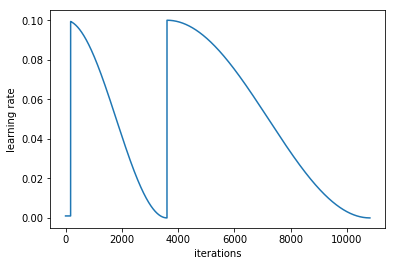

In [172]:
# mul is double lrs after each cycle
ff_learner.sched.plot_lr()

In [111]:
ff_learner.fit(lrs, n_cycle= 2, cycle_len= 1, cycle_mult= 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.124634   0.126036  
    1      0.124      0.12732                                 
    2      0.123218   0.12623                                 
    3      0.122649   0.125526                                


[array([0.12553])]

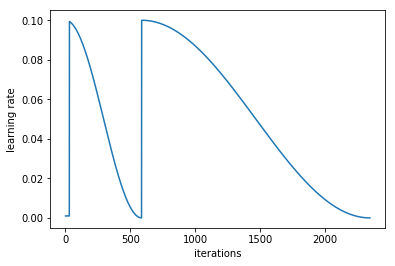

In [112]:
ff_learner.sched.plot_lr()

In [113]:
ff_learner.fit(lrs, n_cycle= 2, cycle_len= 2, cycle_mult= 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.1229     0.125939  
    1      0.122899   0.12561                                 
    2      0.124095   0.127909                                
    3      0.122402   0.126208                                
    4      0.123343   0.126537                                
    5      0.122139   0.125973                                
    6      0.12193    0.125806                                
    7      0.121735   0.125764                                


[array([0.12576])]

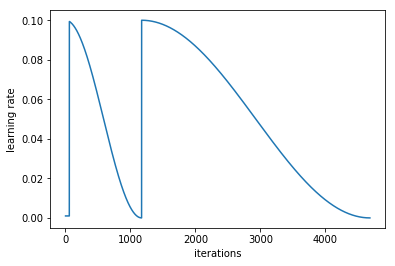

In [114]:
ff_learner.sched.plot_lr()

## 1cycle policy

### first

The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower.
Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.

https://sgugger.github.io/the-1cycle-policy.html

Large cycle, smaller iterator may be better

In [205]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = imbalance_loss

In [204]:
lrs = 1 #which is one tenth of the point where the loss starts to increase a lot, to 3.

Learning rate max: 0.5, 1 cycle of length 80 with 1e-4 of weight decays. 
The arguments of the use_clr_beta tuples mean:
    pick 1/10th of the maximum learning rate for the minimum learning rate
    dedicate 13.68% of the cycle to the annealing at the end (that's 13 epochs over 95)
    maximum momentum 0.95
    minimum momentum 0.85

In [206]:
cycle_len= 50
ff_learner.fit(lrs, n_cycle= 1, cycle_len= cycle_len, use_clr_beta=(10,13.68,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.133104   0.134428  
    1      0.131      0.135785                                  
    2      0.131779   0.132057                                 
    3      0.13361    0.13968                                  
    4      0.134994   0.140288                                 
    5      0.133196   0.134005                                 
    6      0.136475   0.135204                                  
    7      0.134974   0.131486                                  
    8      0.136605   0.135696                                  
    9      0.139621   0.153969                                  
    10     0.141782   0.142712                                  
    11     0.14209    0.142797                                  
    12     0.140865   0.141078                                  
    13     0.138971   0.139696                                 
    14     0.142398   0.142758                                

[array([0.14255])]

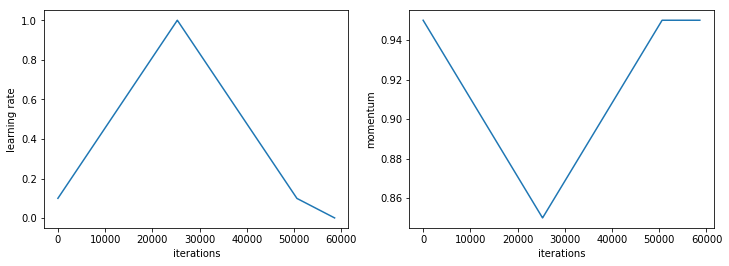

In [207]:
ff_learner.sched.plot_lr()

In [221]:
def plot_loss(cylen, learner):
    fig,ax = plt.subplots(1,1,figsize=(8,5))
    step = len(learner.sched.losses)//len(learner.sched.val_losses)
    ax.plot(list(range(cylen)),
            learner.sched.val_losses, 
            label='Validation loss')
    
    ax.plot(list(range(cylen)),
            [learner.sched.losses[i] for i in range(step-1,cylen*step,step-1)],
            label='Training loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')

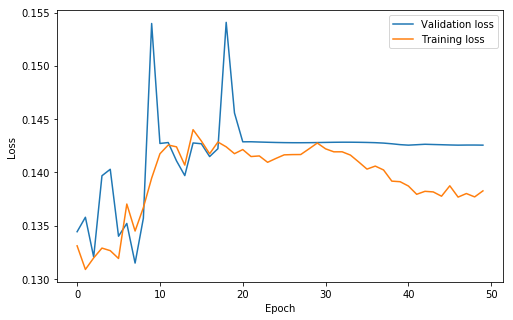

In [222]:
plot_loss(cycle_len, ff_learner)

### smaller cycle

In [223]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = imbalance_loss

In [224]:
lrs = 1
cycle_len = 30
ff_learner.fit(lrs, n_cycle= 1, cycle_len= cycle_len, use_clr_beta=(10,50,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.141843   0.142575  
    1      0.141878   0.142773                                  
    2      0.141985   0.142825                                  
    3      0.142105   0.142819                                  
    4      0.142203   0.142785                                  
    5      0.14227    0.14279                                   
    6      0.142312   0.142844                                  
    7      0.142312   0.142846                                  
    8      0.142272   0.14279                                   
    9      0.14221    0.142782                                  
    10     0.142117   0.142817                                  
    11     0.141998   0.142825                                  
    12     0.14189    0.14277                                   
    13     0.141846   0.142582                                  
    14     0.141748   0.142636                           

[array([0.14255])]

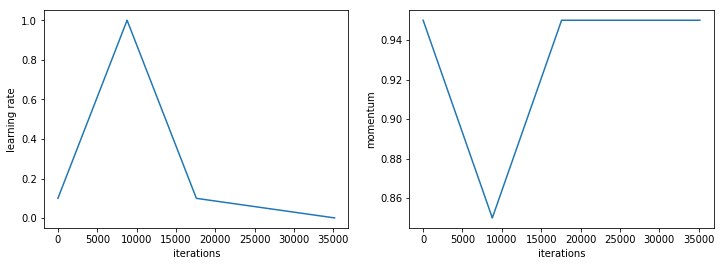

In [225]:
ff_learner.sched.plot_lr()

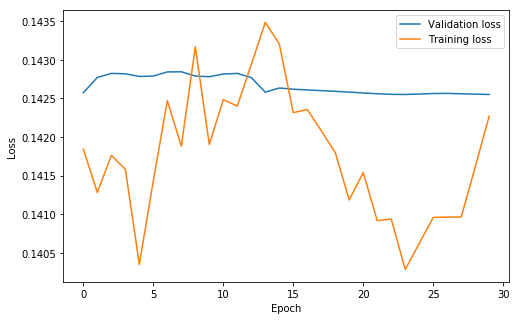

In [226]:
plot_loss(cycle_len, ff_learner)

### higher learning rate

In [229]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = imbalance_loss

In [230]:
lrs = 3
cycle_len = 30
ff_learner.fit(lrs, n_cycle= 1, cycle_len= cycle_len, use_clr_beta=(10,10,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.142215   0.143012  
    1      0.142745   0.142809                                  
    2      0.143239   0.142599                                  
    3      0.143263   0.143273                                  
    4      0.14324    0.144353                                  
    5      0.143388   0.144931                                 
    6      0.143531   0.144783                                 
    7      0.143621   0.144101                                  
    8      0.143679   0.143328                                  
    9      0.143666   0.142747                                  
    10     0.143562   0.142552                                  
    11     0.14341    0.142735                                  
    12     0.143268   0.143114                                  
    13     0.143265   0.143119                                  
    14     0.143404   0.14274                              

[array([0.14255])]

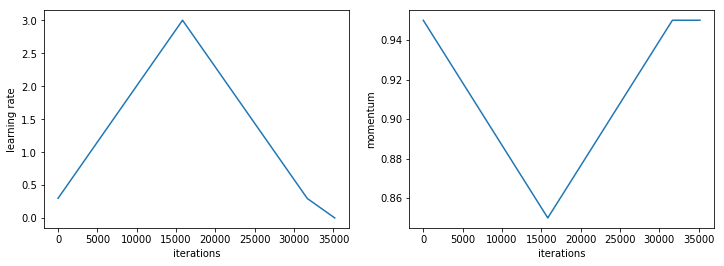

In [231]:
ff_learner.sched.plot_lr()

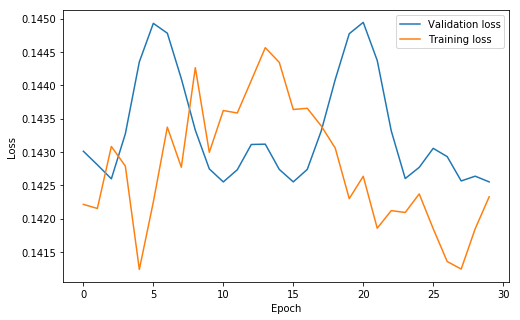

In [232]:
plot_loss(cycle_len, ff_learner)

## AdamW

http://www.fast.ai/2018/07/02/adam-weight-decay/

In [299]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = imbalance_loss

In [301]:
lrs = 0.1
ff_learner.fit(lrs, n_cycle= 3, cycle_len= 1, wds=1e-5, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.130545   0.132614  
    1      0.129428   0.134018                                  
    2      0.128116   0.130573                                  


[array([0.13057])]